get dataset: https://github.com/tkipf/gcn/tree/master/gcn/data


In [1]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import numpy as np
import pickle as pkl
import networkx as nx
import scipy.sparse as sp
from scipy.sparse.linalg import eigsh
import sys
import torch.optim as optim


from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [2]:
## Trying other datasets...

from ogb.graphproppred import PygGraphPropPredDataset
from torch_geometric.data import DataLoader

# Download and process data at './dataset/ogbg_molhiv/'
dataset = PygGraphPropPredDataset(name = "ogbg-molhiv", root = 'data/')

/home/vimarsh/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
## Trying other datasets...

# bio-CE-LC.edges
filename = 'bio-CE-LC'

# Read the edge list file
with open('data/bio-CE-LC.edges', 'r') as f:
    edges = [line.strip().split() for line in f]

# Extract nodes and edges from the edge list
nodes = set()
for edge in edges:
    nodes.update(edge[:2])  # Extracting only source and target nodes

# Generate or extract node features
node_features = {node: [] for node in nodes}

# Generate or extract target labels (assuming you want to predict edge weights)
target_labels = {}

for edge in edges:
    source_node, target_node, edge_weight = edge
    node_features[source_node].append(float(edge_weight))
    node_features[target_node].append(float(edge_weight))
    target_labels[(source_node, target_node)] = float(edge_weight)

# Write node features to .x file
with open('data/ind.'+filename+'.x', 'w') as f:
    for node, features in node_features.items():
        f.write(f"{node} {' '.join(map(str, features))}\n")

# Write target labels to .y file
with open('data/ind.'+filename+'.y', 'w') as f:
    for (source_node, target_node), label in target_labels.items():
        f.write(f"{source_node} {target_node} {label}\n")


In [4]:
def sparse_to_tuple(sparse_mx):
    """Convert sparse matrix to tuple representation."""
    def to_tuple(mx):
        if not sp.isspmatrix_coo(mx):
            mx = mx.tocoo()
        coords = np.vstack((mx.row, mx.col)).transpose()
        values = mx.data
        shape = mx.shape
        return coords, values, shape

    if isinstance(sparse_mx, list):
        for i in range(len(sparse_mx)):
            sparse_mx[i] = to_tuple(sparse_mx[i])
    else:
        sparse_mx = to_tuple(sparse_mx)

    return sparse_mx

def preprocess_features(features):
    """Row-normalize feature matrix and convert to tuple representation"""
    rowsum = np.array(features.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    features = r_mat_inv.dot(features)
    return features.todense(), sparse_to_tuple(features)

def adj_to_bias(adj, sizes, nhood=1):
    nb_graphs = adj.shape[0]
    mt = np.empty(adj.shape)
    for g in range(nb_graphs):
        mt[g] = np.eye(adj.shape[1])
        for _ in range(nhood):
            mt[g] = np.matmul(mt[g], (adj[g] + np.eye(adj.shape[1])))
        for i in range(sizes[g]):
            for j in range(sizes[g]):
                if mt[g][i][j] > 0.0:
                    mt[g][i][j] = 1.0
    return -1e9 * (1.0 - mt)

def parse_index_file(filename):
    """Parse index file."""
    index = []
    for line in open(filename):
        index.append(int(line.strip()))
    return index

def sample_mask(idx, l):
    """Create mask."""
    mask = np.zeros(l)
    mask[idx] = 1
    return np.array(mask, dtype=bool)

In [5]:
def load_data(dataset_str): # {'pubmed', 'citeseer', 'cora'}
    """Load data."""
    names = ['x', 'y', 'tx', 'ty', 'allx', 'ally', 'graph']
    objects = []
    for i in range(len(names)):
        with open("data/ind.{}.{}".format(dataset_str, names[i]), 'rb') as f:
            if sys.version_info > (3, 0):
                objects.append(pkl.load(f, encoding='latin1'))
            else:
                objects.append(pkl.load(f))

    x, y, tx, ty, allx, ally, graph = tuple(objects)
    test_idx_reorder = parse_index_file("data/ind.{}.test.index".format(dataset_str))
    test_idx_range = np.sort(test_idx_reorder)

    if dataset_str == 'citeseer':
        # Fix citeseer dataset (there are some isolated nodes in the graph)
        # Find isolated nodes, add them as zero-vecs into the right position
        test_idx_range_full = range(min(test_idx_reorder), max(test_idx_reorder)+1)
        tx_extended = sp.lil_matrix((len(test_idx_range_full), x.shape[1]))
        tx_extended[test_idx_range-min(test_idx_range), :] = tx
        tx = tx_extended
        ty_extended = np.zeros((len(test_idx_range_full), y.shape[1]))
        ty_extended[test_idx_range-min(test_idx_range), :] = ty
        ty = ty_extended

    features = sp.vstack((allx, tx)).tolil()
    features[test_idx_reorder, :] = features[test_idx_range, :]
    adj = nx.adjacency_matrix(nx.from_dict_of_lists(graph))

    labels = np.vstack((ally, ty))
    labels[test_idx_reorder, :] = labels[test_idx_range, :]

    my_labels = np.where(labels==1)[1]
    idx_test = test_idx_range.tolist()
    idx_train = range(len(y))
    idx_val = range(len(y), len(y)+500)

    train_my_labels_mask = sample_mask(idx_train, my_labels.shape[0])
    val_my_labels_mask = sample_mask(idx_val, my_labels.shape[0])
    test_my_labels_mask = sample_mask(idx_test, my_labels.shape[0])
    train_my_labels = my_labels[train_my_labels_mask]
    val_my_labels = my_labels[val_my_labels_mask]
    test_my_labels = my_labels[test_my_labels_mask]

    train_mask = sample_mask(idx_train, labels.shape[0])
    val_mask = sample_mask(idx_val, labels.shape[0])
    test_mask = sample_mask(idx_test, labels.shape[0])

    y_train = np.zeros(labels.shape)
    y_val = np.zeros(labels.shape)
    y_test = np.zeros(labels.shape)
    y_train[train_mask, :] = labels[train_mask, :]
    y_val[val_mask, :] = labels[val_mask, :]
    y_test[test_mask, :] = labels[test_mask, :]

    print(adj.shape)
    print(features.shape)
    data_dict = {
      'adj': adj,
      'features': features,
      'y_train': y_train,
      'y_val': y_val,
      'y_test': y_test,
      'train_mask': train_mask,
      'val_mask': val_mask,
      'test_mask': test_mask,
      'train_my_labels': train_my_labels,
      'val_my_labels': val_my_labels,
      'test_my_labels': test_my_labels,
      'my_labels': my_labels
    }
    return data_dict


In [6]:
class Attn_head(nn.Module):
  def __init__(self, 
        in_channel, 
        out_sz, 
        bias_mat, 
        in_drop=0.0, 
        coef_drop=0.0, 
        activation=None,
        residual=False):
    super(Attn_head, self).__init__() 
    self.in_channel = in_channel
    self.out_sz = out_sz 
    self.bias_mat = bias_mat
    self.in_drop = in_drop
    self.coef_drop = coef_drop
    self.activation = activation
    self.residual = residual
    
    self.conv1 = nn.Conv1d(self.in_channel, self.out_sz, 1)
    self.conv2_1 = nn.Conv1d(self.out_sz, 1, 1)
    self.conv2_2 = nn.Conv1d(self.out_sz, 1, 1)
    self.leakyrelu = nn.LeakyReLU()
    self.softmax = nn.Softmax(dim=1)
    self.in_dropout = nn.Dropout()
    self.coef_dropout = nn.Dropout()
    self.res_conv = nn.Conv1d(self.in_channel, self.out_sz, 1)
  
  def forward(self,x):
    seq = x
    if self.in_drop != 0.0:
      seq = self.in_dropout(x)
    seq_fts = self.conv1(seq)
    f_1 = self.conv2_1(seq_fts)
    f_2 = self.conv2_2(seq_fts)
    logits = f_1 + torch.transpose(f_2, 2, 1)
    logits = self.leakyrelu(logits)
    coefs = self.softmax(logits + self.bias_mat)
    if self.coef_drop !=0.0:
      coefs = self.coef_dropout(coefs)
    if self.in_dropout !=0.0:
      seq_fts = self.in_dropout(seq_fts)
    ret = torch.matmul(coefs, torch.transpose(seq_fts, 2, 1))
    ret = torch.transpose(ret, 2, 1)
    if self.residual:
      if seq.shape[1] != ret.shape[1]:
        ret = ret + self.res_conv(seq)
      else:
        ret = ret + seq
    return self.activation(ret)

In [7]:
class GAT(nn.Module):
  def __init__(self,
      nb_classes, 
      nb_nodes, 
      attn_drop, 
      ffd_drop, 
      bias_mat, 
      hid_units, 
      n_heads, 
      residual=False):
    super(GAT, self).__init__()  
    self.nb_classes = nb_classes
    self.nb_nodes = nb_nodes
    self.attn_drop = attn_drop
    self.ffd_drop = ffd_drop
    self.bias_mat = bias_mat
    self.hid_units = hid_units
    self.n_heads = n_heads
    self.residual = residual

    self.attn1 = Attn_head(in_channel=1433, out_sz=self.hid_units[0],
                bias_mat=self.bias_mat, in_drop=self.ffd_drop,
                coef_drop=self.attn_drop, activation=nn.ELU(),
                residual=self.residual)
    self.attn2 = Attn_head(in_channel=64, out_sz=self.nb_classes,
                bias_mat=self.bias_mat, in_drop=self.ffd_drop,
                coef_drop=self.attn_drop, activation=nn.ELU(),
                residual=self.residual)
    self.softmax = nn.Softmax(dim=1)
  
  def forward(self, x):
    attns = []
    for _ in range(self.n_heads[0]):
      attns.append(self.attn1(x))
    h_1 = torch.cat(attns, dim=1)
    out = self.attn2(h_1)
    logits = torch.transpose(out.view(self.nb_classes,-1), 1, 0)
    logits = self.softmax(logits)
    return logits

In [8]:
np.random.seed(37)
torch.manual_seed(37)
torch.cuda.manual_seed_all(37)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data = load_data("cora")
# data = load_data("bio-CE-LC")

adj = data['adj']
features = data['features']
y_train = data['y_train']
y_val = data['y_val']
y_test = data['y_test']
train_mask = data['train_mask']
val_mask = data['val_mask']
test_mask = data['test_mask']
train_my_labels = data['train_my_labels']
val_my_labels = data['val_my_labels']
test_my_labels = data['test_my_labels']
my_labels = data['my_labels']

features, spars = preprocess_features(features)

nb_nodes = features.shape[0]
ft_sizes = features.shape[1]
nb_classes = my_labels.shape[0]

adj = adj.todense()

adj = adj[np.newaxis]
features = features[np.newaxis]
y_train = y_train[np.newaxis]
y_val = y_val[np.newaxis]
y_test = y_test[np.newaxis]
#train_mask = train_mask[np.newaxis]
#val_mask = val_mask[np.newaxis]
#test_mask = test_mask[np.newaxis]

biases = torch.from_numpy(adj_to_bias(adj, [nb_nodes], nhood=1)).float().to(device)

features = torch.from_numpy(features)
#pytorch: [batch, features，nodes]，
features = torch.transpose(features,2,1).to(device)

/tmp/ipykernel_331423/2880381957.py:8: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  objects.append(pkl.load(f, encoding='latin1'))


(2708, 2708)
(2708, 1433)


In [9]:
hid_units=[8]
n_heads=[8, 1]
epochs = 100
lr = 0.01

gat = GAT(nb_classes=nb_classes,
      nb_nodes=nb_nodes, 
      attn_drop=0.0, 
      ffd_drop=0.0, 
      bias_mat=biases, 
      hid_units=hid_units, 
      n_heads=n_heads, 
      residual=False).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=gat.parameters(),lr=lr,betas=(0.9, 0.99))


#y_train = torch.from_numpy(np.where(y_train==1)[2])
#y_val = torch.from_numpy(np.where(y_val==1)[2])
#y_test = torch.from_numpy(np.where(y_test==1)[2])
train_my_labels = torch.from_numpy(train_my_labels).long().to(device)
val_my_labels = torch.from_numpy(val_my_labels).long().to(device)
test_my_labels = torch.from_numpy(test_my_labels).long().to(device)

train_mask = np.where(train_mask == 1)[0]
val_mask = np.where(val_mask == 1)[0]
test_mask = np.where(test_mask == 1)[0]
train_mask = torch.from_numpy(train_mask).to(device)
val_mask = torch.from_numpy(val_mask).to(device)
test_mask = torch.from_numpy(test_mask).to(device)

print("number of labels in train set: ", len(train_my_labels))
print("no of labels in val set: ", len(val_my_labels))
print("no of labels in test set: ", len(test_my_labels))

number of labels in train set:  140
no of labels in val set:  500
no of labels in test set:  1000


In [10]:
def train():
  gat.train()
  correct = 0
  optimizer.zero_grad()
  outputs = gat(features)
  train_mask_outputs = torch.index_select(outputs, 0, train_mask)
  #print("train_mask_outputs.shape:",train_mask_outputs.shape)
  #print("train_my_labels.shape[0]:",train_my_labels.shape[0])
  _, preds =torch.max(train_mask_outputs.data, 1)
  loss = criterion(train_mask_outputs, train_my_labels)
  loss.backward()
  optimizer.step()
  correct += torch.sum(preds == train_my_labels).to(torch.float32)
  acc = correct / train_my_labels.shape[0]
  return loss,acc


def val():
  gat.eval()
  with torch.no_grad():
    correct = 0
    outputs = gat(features)
    val_mask_outputs = torch.index_select(outputs, 0, val_mask)
    #print("val_mask_outputs.shape:",val_mask_outputs.shape)
    #print("val_my_labels.shape[0]:",val_my_labels.shape[0])
    _, preds =torch.max(val_mask_outputs.data, 1)
    loss = criterion(val_mask_outputs, val_my_labels)
    correct += torch.sum(preds == val_my_labels).to(torch.float32)
    acc = correct / val_my_labels.shape[0]
  return loss,acc

def test():
  gat.eval()
  with torch.no_grad():
    correct = 0
    outputs = gat(features)
    test_mask_outputs = torch.index_select(outputs, 0, test_mask)
    #print("test_mask_outputs.shape:",test_mask_outputs.shape)
    #print("val_my_labels.shape[0]:",val_my_labels.shape[0])
    _, preds =torch.max(test_mask_outputs.data, 1)
    loss = criterion(test_mask_outputs, test_my_labels)
    correct += torch.sum(preds == test_my_labels).to(torch.float32)
    acc = correct / test_my_labels.shape[0]
    print("TestLoss:{:.4f},TestAcc:{:.4f}".format(loss,acc))
  return loss,acc,test_mask_outputs.cpu().numpy(),test_my_labels.cpu().numpy()

In [11]:
def main():
  train_loss_history = []
  val_loss_history = []
  train_acc_history = []
  val_acc_history = []
  for epoch in range(1,epochs+1):
    train_loss,train_acc = train()
    val_loss,val_acc = val()
    print("epoch:{:03d},TrainLoss:{:.4f},TrainAcc:{:.4f},ValLoss:{:.4f},ValAcc:{:.4f}"
        .format(epoch,train_loss,train_acc,val_loss,val_acc))
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)
  
  num_epochs = range(1, epochs + 1)
  
  ## convert to normal numpy array
  train_loss_history = [x.cpu().detach().numpy() for x in train_loss_history]
  val_loss_history = [x.cpu().detach().numpy() for x in val_loss_history]
  train_acc_history = [x.cpu().detach().numpy() for x in train_acc_history]
  val_acc_history = [x.cpu().detach().numpy() for x in val_acc_history]
  
  plt.plot(num_epochs, train_loss_history , 'b--')
  plt.plot(num_epochs, val_loss_history , 'r-')
  plt.title('Training and validation Loss ')
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend(["train_loss", 'val_loss'])
  plt.savefig("loss.png")
  plt.show()
  plt.close()

  plt.plot(num_epochs, train_acc_history, 'b--')
  plt.plot(num_epochs, val_acc_history, 'r-')
  plt.title('Training and validation Acc ')
  plt.xlabel("Epochs")
  plt.ylabel("Acc")
  plt.legend(['train_acc','val_acc'])
  plt.savefig("acc.png")
  plt.show()
  plt.close()

  _, _, test_data, test_labels = test()
  tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=250) 
  low_dim_embs = tsne.fit_transform(test_data)
  plt.title('tsne result')
  plt.scatter(low_dim_embs[:,0], low_dim_embs[:,1], marker='o', s=5, c=test_labels)
  plt.savefig("tsne.png")
  plt.show()
  plt.close()

epoch:001,TrainLoss:7.9040,TrainAcc:0.0000,ValLoss:7.9040,ValAcc:0.0000
epoch:002,TrainLoss:7.9040,TrainAcc:0.0000,ValLoss:7.9040,ValAcc:0.0000
epoch:003,TrainLoss:7.9040,TrainAcc:0.0000,ValLoss:7.9039,ValAcc:0.1220
epoch:004,TrainLoss:7.9039,TrainAcc:0.0286,ValLoss:7.9039,ValAcc:0.2000
epoch:005,TrainLoss:7.9039,TrainAcc:0.1000,ValLoss:7.9039,ValAcc:0.1380
epoch:006,TrainLoss:7.9039,TrainAcc:0.1500,ValLoss:7.9038,ValAcc:0.1140
epoch:007,TrainLoss:7.9038,TrainAcc:0.1714,ValLoss:7.9037,ValAcc:0.1140
epoch:008,TrainLoss:7.9037,TrainAcc:0.1429,ValLoss:7.9036,ValAcc:0.1140
epoch:009,TrainLoss:7.9036,TrainAcc:0.1500,ValLoss:7.9035,ValAcc:0.1140
epoch:010,TrainLoss:7.9034,TrainAcc:0.1429,ValLoss:7.9033,ValAcc:0.1140
epoch:011,TrainLoss:7.9032,TrainAcc:0.1429,ValLoss:7.9029,ValAcc:0.1140
epoch:012,TrainLoss:7.9028,TrainAcc:0.1857,ValLoss:7.9027,ValAcc:0.1140
epoch:013,TrainLoss:7.9028,TrainAcc:0.1286,ValLoss:7.9017,ValAcc:0.1140
epoch:014,TrainLoss:7.9010,TrainAcc:0.1714,ValLoss:7.9010,ValAcc

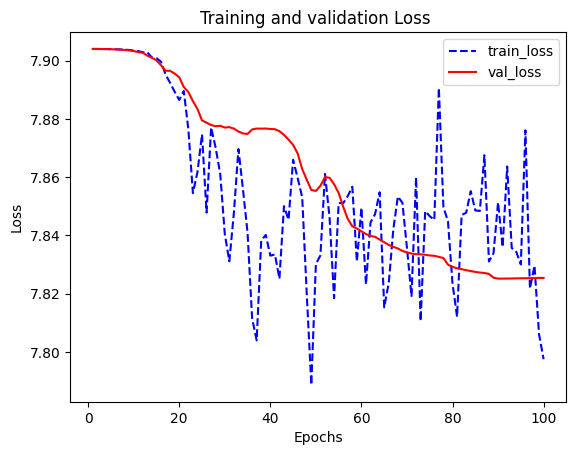

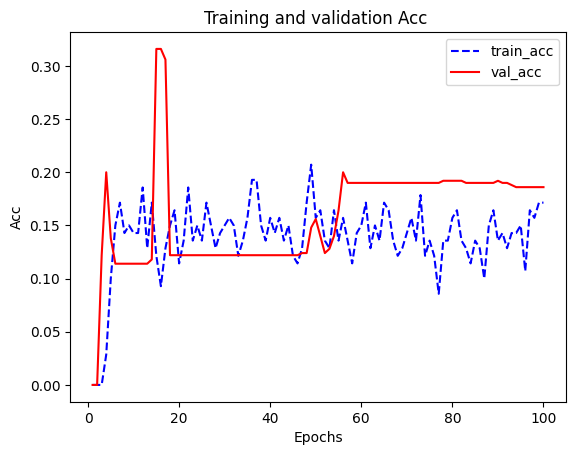

TestLoss:7.8337,TestAcc:0.1860


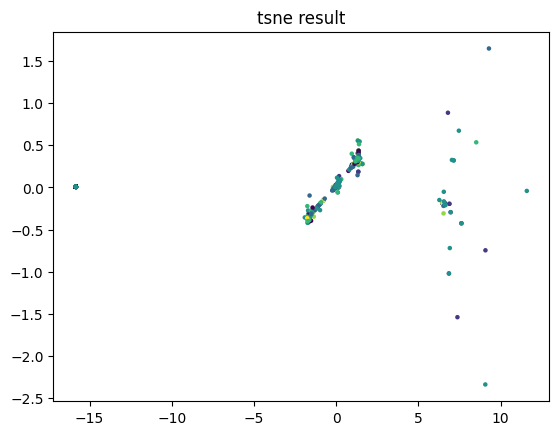

In [12]:
main()